In [1]:
import os
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torchvision
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import common
from preprocess import preprocess

C:\tools\miniconda3\envs\facial-beauty-prediction-with-vision-transformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def determine_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'


device = determine_device()
print(f'Device is {device}')

Device is cuda


In [3]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=1)
model = model.to(device)

config = resolve_data_config({}, model=model)
print(config)
model_transform = create_transform(**config)
composed_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-5, 5)),
    model_transform
])
print(composed_transform)

{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9, 'crop_mode': 'center'}
Compose(
    RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
    Compose(
    Resize(size=248, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.5000, 0.5000, 0.5000]), std=tensor([0.5000, 0.5000, 0.5000]))
)
)


In [4]:
class CustomImageDataset(Dataset):

    def __init__(self, transform=None):
        outputs_dir = common.outputs_dir()
        dataset_file = os.path.join(outputs_dir, 'dataset', 'dataset.pt')
        x, y, sigma = torch.load(dataset_file, weights_only=True)
        self.x = x
        self.y = y.unsqueeze(dim=-1)
        self.sigma = sigma
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.x[idx]
        return image if self.transform is None else self.transform(image), self.y[idx]


dataset = CustomImageDataset(transform=composed_transform)
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [5]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

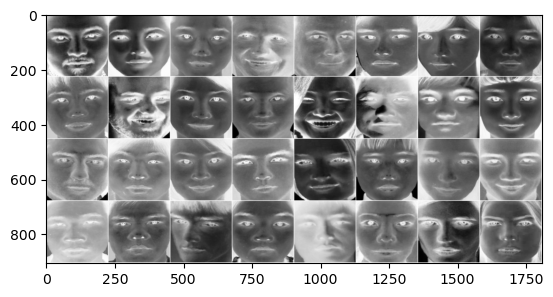

In [6]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [7]:
index = 6
train_features, train_labels = next(iter(train_dataloader))
outputs_dir = os.path.join(os.getcwd(), "outputs")
cv2.imwrite(os.path.join(outputs_dir, f"output_{index}.jpg"), train_features[index].numpy().transpose((1, 2, 0)))

True

In [8]:
train_features, train_labels = next(iter(train_dataloader))
train_features = train_features.to(device)
train_labels = train_labels.to(device)
model(train_features)


tensor([[-1.0610],
        [-1.0895],
        [-0.8656],
        [-1.3458],
        [-1.0166],
        [-1.3674],
        [-1.2696],
        [-1.1839],
        [-0.9202],
        [-0.8575],
        [-1.1604],
        [-0.9395],
        [-1.2381],
        [-0.7684],
        [-1.3331],
        [-1.3797],
        [-0.9135],
        [-1.4005],
        [-1.4236],
        [-0.8831],
        [-0.8547],
        [-1.2562],
        [-1.5254],
        [-1.3518],
        [-1.3549],
        [-1.3103],
        [-1.0023],
        [-0.9401],
        [-1.3504],
        [-1.2165],
        [-1.0360],
        [-1.3247]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [9]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = MSELoss()

In [10]:
# See https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html.
REPORT_EVERY = 10


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        x, y = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(x)

        # Compute the loss and its gradients
        loss = criterion(outputs, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % REPORT_EVERY == REPORT_EVERY - 1:
            last_loss = running_loss / REPORT_EVERY  # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [11]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

# At most 40 should be enough.
EPOCHS = 100

best_val_loss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_val_loss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, val_data in enumerate(valid_dataloader):
            val_x, val_y = val_data
            val_y_pred = model(val_x.to(device))
            val_loss = criterion(val_y_pred, val_y.to(device))
            running_val_loss += val_loss

    avg_val_loss = running_val_loss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_val_loss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_val_loss},
                       epoch_number + 1)
    writer.flush()

    # Track the best performance, and save the model's state
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 10 loss: 25.480291259288787
  batch 20 loss: 0.6261014580726624
  batch 30 loss: 0.5188912689685822
  batch 40 loss: 0.47405803501605986
  batch 50 loss: 0.5179299116134644
  batch 60 loss: 0.524049487709999
  batch 70 loss: 0.48572230637073516
  batch 80 loss: 0.45595934689044954
  batch 90 loss: 0.4159704834222794
  batch 100 loss: 0.49446624517440796
  batch 110 loss: 0.4517841339111328
  batch 120 loss: 0.4882751017808914
  batch 130 loss: 0.5211890876293183
LOSS train 0.5211890876293183 valid 0.5958687663078308
EPOCH 2:
  batch 10 loss: 0.5151582151651383
  batch 20 loss: 0.43386319279670715
  batch 30 loss: 0.5373305022716522
  batch 40 loss: 0.46088625192642213
  batch 50 loss: 0.46392006874084474
  batch 60 loss: 0.45109357237815856
  batch 70 loss: 0.47416333556175233
  batch 80 loss: 0.43083795458078383
  batch 90 loss: 0.3778806686401367
  batch 100 loss: 0.4467271327972412
  batch 110 loss: 0.4849278420209885
  batch 120 loss: 0.4396605581045151
  batch 130

In [20]:
model.eval()
image = cv2.imread(
    # r'C:\dev\git_home\ai-sandbox\facial-beauty-prediction-with-vision-transformer\outputs\SCUT-FBP5500_v2\Images\AF1174.jpg')
r'C:\Users\yaskovdev\Desktop\Screenshot 2025-07-12 225847.png')
preprocessed_image = preprocess(image)
image_tensor = torch.tensor((preprocessed_image.transpose((2, 0, 1))), dtype=torch.float32)
x = model_transform(image_tensor).unsqueeze(0).to(device)
with torch.no_grad():
    print(model(x))

Faces:
 [[333 106 443 443]]
tensor([[3.1572]], device='cuda:0')
